# Modelo A para clasificación de imagenes

#### Jeffrey Daniel Leiva Cascante 2021016720
#### Richard Osvaldo León Chinchilla 2019003759

## Inicialización

In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resnet es de 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomRotation(20),  # Rotación aleatoria
    transforms.RandomHorizontalFlip(),  # Inversión horizontal aleatoria
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variación de brillo y contraste
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    
])

# Cargamos el dataset de entrenamiento para cada dataset
train_dataset = datasets.ImageFolder(root='./Covid19-dataset/train', transform=transform)
train_dataset_bilateral = datasets.ImageFolder(root='./Covid19-dataset-bilateral/train', transform=transform)
train_dataset_canny = datasets.ImageFolder(root='./Covid19-dataset-canny/train', transform=transform)

# Cargamos el dataset de test para cada dataset
test_dataset = datasets.ImageFolder(root='./Covid19-dataset/test', transform=transform_test)
test_dataset_bilateral = datasets.ImageFolder(root='./Covid19-dataset-bilateral/test', transform=transform_test)
test_dataset_canny = datasets.ImageFolder(root='./Covid19-dataset-canny/test', transform=transform_test)

val_percent = 0.15 # Porcentaje de imágenes que se usarán para validación

# Calculamos el tamaño de los conjuntos de entrenamiento y validación
val_size = int(val_percent * len(train_dataset))
train_size = len(train_dataset) - val_size

val_size_bilateral = int(val_percent * len(train_dataset_bilateral))
train_size_bilateral = len(train_dataset_bilateral) - val_size_bilateral

val_size_canny = int(val_percent * len(train_dataset_canny))
train_size_canny = len(train_dataset_canny) - val_size_canny

# Se divide el dataset en dos
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_dataset_bilateral, val_dataset_bilateral = random_split(train_dataset_bilateral, [train_size_bilateral, val_size_bilateral])
train_dataset_canny, val_dataset_canny = random_split(train_dataset_canny, [train_size_canny, val_size_canny])

# Aplicamos el transformador de testing a los conjuntos de validación
val_dataset.dataset.transform = transform_test
val_dataset_bilateral.dataset.transform = transform_test
val_dataset_canny.dataset.transform = transform_test

# Creamos los dataloaders para cada dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader_bilateral = DataLoader(train_dataset_bilateral, batch_size=32, shuffle=True)
val_loader_bilateral = DataLoader(val_dataset_bilateral, batch_size=32, shuffle=False)
test_loader_bilateral = DataLoader(test_dataset_bilateral, batch_size=32, shuffle=False)

train_loader_canny = DataLoader(train_dataset_canny, batch_size=32, shuffle=True)
val_loader_canny = DataLoader(val_dataset_canny, batch_size=32, shuffle=False)
test_loader_canny = DataLoader(test_dataset_canny, batch_size=32, shuffle=False)





### Weights and Biases

In [2]:
import wandb
wandb.login(
    key="52cc20b894f4ec68c5e30b411f8f55148e7e54ec"
)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: r29leonc (iaredescnncnn-instituto-tecnol-gico-de-costa-rica). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\richa\_netrc


True

## Carga de Resnet-50 preentrenado

In [3]:
import torch.nn as nn
import torchvision.models as models

# Cargamos el modelo preentrenado
resnet50  = models.resnet50(pretrained=True)

# Se modifica la capa final para adaptarla a 3 clases
num_classes = 3
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)

# Se congela el modelo para que no se actualicen los pesos de las capas preentrenadas
for param in resnet50.parameters():
    param.requires_grad = False

for param in resnet50.fc.parameters():
    param.requires_grad = True

# Se mueve el modelo a la GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = resnet50.to(device)

# Solo los parametros de la capa final se entrenan
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.001)

# Se define la función de pérdida
criterion = nn.CrossEntropyLoss()

c:\Users\richa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\richa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Entrenamiento

In [4]:
wandb.init(project='Model-A')

wandb.config={
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 10,
    'optimizer': 'Adam',
}
wandb.watch(resnet50, log='all', log_freq=10)

def train_model(train_loader,val_loader,n_epochs,best_val_acc=0.0,name_model='best_model.pth'):
    for epoch in range(n_epochs):
        resnet50.train()
        train_loss = 0.0 
     
        # Entrenamiento
        for input,labels in train_loader: # Se recorren los datos de entrenamiento
            inputs, labels = input.to(device), labels.to(device)
            optimizer.zero_grad() # Se reinician los gradientes
            outputs = resnet50(inputs) # Se obtiene la salida del modelo
            loss = criterion(outputs, labels) # Se calcula la pérdida
 
            loss.backward() # Se calculan los gradientes
            optimizer.step() # Se actualizan los pesos

            train_loss += loss.item() * inputs.size(0)
            _,predicted = torch.max(outputs, 1)
            corrects = torch.sum(predicted == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = corrects.double() / len(train_loader.dataset)

        #Validación
        resnet50.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad(): # No se calculan los gradientes en la validación
            for inputs,labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = resnet50(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _,predicted = torch.max(outputs, 1)
                val_corrects += torch.sum(predicted == labels.data)

            val_loss = val_loss/len(val_loader.dataset)
            val_acc = val_corrects.double() / len(val_loader.dataset)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(resnet50.state_dict(), name_model)
                print(f"Mejor modelo guardado con accuracy: {best_val_acc}")

            wandb.log({
                "Epoch": epoch,
                "Train Loss": train_loss,
                "Train Acc": train_acc,
                "Val Loss": val_loss,
                "Val Acc": val_acc,
            })
            print('Epoch: {} Train Loss: {:.4f} Train Acc: {:.4f} Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch, train_loss, train_acc, val_loss, val_acc))




### Dataset Crudo

In [5]:
train_model(train_loader, val_loader, 20,name_model='ModelA_raw.pth')

Mejor modelo guardado con accuracy: 0.7837837837837838
Epoch: 0 Train Loss: 1.0127 Train Acc: 0.0474 Val Loss: 0.8009 Val Acc: 0.7838
Mejor modelo guardado con accuracy: 0.8378378378378379
Epoch: 1 Train Loss: 0.6937 Train Acc: 0.0853 Val Loss: 0.5597 Val Acc: 0.8378
Mejor modelo guardado con accuracy: 0.918918918918919
Epoch: 2 Train Loss: 0.5519 Train Acc: 0.0806 Val Loss: 0.4792 Val Acc: 0.9189
Epoch: 3 Train Loss: 0.4676 Train Acc: 0.0758 Val Loss: 0.4258 Val Acc: 0.8649
Epoch: 4 Train Loss: 0.3501 Train Acc: 0.0806 Val Loss: 0.3609 Val Acc: 0.9189
Mejor modelo guardado con accuracy: 0.945945945945946
Epoch: 5 Train Loss: 0.3176 Train Acc: 0.0900 Val Loss: 0.3190 Val Acc: 0.9459
Epoch: 6 Train Loss: 0.3185 Train Acc: 0.0711 Val Loss: 0.2918 Val Acc: 0.9459
Epoch: 7 Train Loss: 0.2319 Train Acc: 0.0900 Val Loss: 0.3371 Val Acc: 0.9189
Epoch: 8 Train Loss: 0.2431 Train Acc: 0.0900 Val Loss: 0.2486 Val Acc: 0.9459
Epoch: 9 Train Loss: 0.2226 Train Acc: 0.0853 Val Loss: 0.2659 Val Acc:

In [6]:
wandb.finish()

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Acc,▁▇▆▆▆█▅██▇████▃▇█▇▇█
Train Loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁
Val Acc,▁▃▇▅▇██▇█▇▇▇▇▇▇▇▇▇▇▇
Val Loss,█▅▄▄▃▃▂▃▂▂▂▁▂▁▁▁▁▂▁▁
Epoch,19
Train Acc,0.09005
Train Loss,0.12639
Val Acc,0.91892
Val Loss,0.19131


### Dataset con filtro Bilateral

In [8]:
train_model(train_loader_bilateral, val_loader_bilateral, 30, name_model='ModelA_bilateral.pth')

Mejor modelo guardado con accuracy: 0.8378378378378379
Epoch: 0 Train Loss: 0.2647 Train Acc: 0.0900 Val Loss: 0.3741 Val Acc: 0.8378
Mejor modelo guardado con accuracy: 0.918918918918919
Epoch: 1 Train Loss: 0.2692 Train Acc: 0.0806 Val Loss: 0.2201 Val Acc: 0.9189
Mejor modelo guardado con accuracy: 0.945945945945946
Epoch: 2 Train Loss: 0.2724 Train Acc: 0.0758 Val Loss: 0.2376 Val Acc: 0.9459
Mejor modelo guardado con accuracy: 1.0
Epoch: 3 Train Loss: 0.2246 Train Acc: 0.0758 Val Loss: 0.1460 Val Acc: 1.0000
Epoch: 4 Train Loss: 0.2420 Train Acc: 0.0758 Val Loss: 0.1661 Val Acc: 1.0000
Epoch: 5 Train Loss: 0.2019 Train Acc: 0.0853 Val Loss: 0.1439 Val Acc: 0.9730
Epoch: 6 Train Loss: 0.1784 Train Acc: 0.0900 Val Loss: 0.1515 Val Acc: 1.0000
Epoch: 7 Train Loss: 0.1596 Train Acc: 0.0900 Val Loss: 0.1340 Val Acc: 0.9730
Epoch: 8 Train Loss: 0.1632 Train Acc: 0.0900 Val Loss: 0.1231 Val Acc: 1.0000
Epoch: 9 Train Loss: 0.1886 Train Acc: 0.0900 Val Loss: 0.1249 Val Acc: 1.0000
Epoch: 

In [9]:
wandb.finish()

Epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Acc,█▃▁▁▁▆██████▆██▃▆██████▃████▃█
Train Loss,███▆▇▆▅▄▄▅▃▃▄▃▃▅▃▂▂▂▂▁▂▂▂▁▂▁▂▁
Val Acc,▁▅▆██▇█▇██▇███████████████████
Val Loss,█▄▅▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▂▁▁▂
Epoch,29
Train Acc,0.09005
Train Loss,0.08039
Val Acc,1
Val Loss,0.12576


### Dataset con filtro Canny

In [11]:
train_model(train_loader_canny, val_loader_canny, 30, name_model='ModelA_canny.pth')

Mejor modelo guardado con accuracy: 0.5945945945945946
Epoch: 0 Train Loss: 0.7707 Train Acc: 0.0569 Val Loss: 1.0191 Val Acc: 0.5946
Mejor modelo guardado con accuracy: 0.8648648648648649
Epoch: 1 Train Loss: 0.6844 Train Acc: 0.0711 Val Loss: 0.3987 Val Acc: 0.8649
Epoch: 2 Train Loss: 0.5236 Train Acc: 0.0806 Val Loss: 0.4592 Val Acc: 0.7838
Mejor modelo guardado con accuracy: 0.8918918918918919
Epoch: 3 Train Loss: 0.4672 Train Acc: 0.0664 Val Loss: 0.3181 Val Acc: 0.8919
Epoch: 4 Train Loss: 0.3782 Train Acc: 0.0806 Val Loss: 0.3322 Val Acc: 0.7838
Epoch: 5 Train Loss: 0.4281 Train Acc: 0.0806 Val Loss: 0.3154 Val Acc: 0.8649
Mejor modelo guardado con accuracy: 0.918918918918919
Epoch: 6 Train Loss: 0.3265 Train Acc: 0.0711 Val Loss: 0.3058 Val Acc: 0.9189
Epoch: 7 Train Loss: 0.2996 Train Acc: 0.0758 Val Loss: 0.3122 Val Acc: 0.9189
Epoch: 8 Train Loss: 0.2547 Train Acc: 0.0711 Val Loss: 0.2726 Val Acc: 0.8919
Epoch: 9 Train Loss: 0.2870 Train Acc: 0.0806 Val Loss: 0.2780 Val Acc

In [12]:
wandb.finish()

Epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Acc,▁▄▆▃▆▆▄▅▄▆█▆▆██▆▅▄▇█████▆▇▆█▆▇
Train Loss,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁
Val Acc,▁▆▅▇▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇█▇
Val Loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,29
Train Acc,0.08531
Train Loss,0.09513
Val Acc,0.91892
Val Loss,0.22495


## Testing

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def test_model(test_loader_p,name_model):
    # Se carga el modelo
    resnet50.load_state_dict(torch.load(name_model))
    resnet50.eval()
    test_corrects = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs,labels in test_loader_p:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            _,predicted = torch.max(outputs, 1)
            test_corrects += torch.sum(predicted == labels.data)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        all_predictions = np.array(all_predictions)   
        all_labels = np.array(all_labels)

        # Accuracy, precision, recall y F1
        test_acc = test_corrects.double() / len(test_loader.dataset)
        precision = precision_score(all_labels, all_predictions, average='macro')
        recall = recall_score(all_labels, all_predictions, average='macro')
        f1 = f1_score(all_labels, all_predictions, average='macro')
    
        print('Accuracy: {:.4f}'.format(test_acc)) 
        print('Precision: {:.4f}'.format(precision))
        print('Recall: {:.4f}'.format(recall))
        print('F1: {:.4f}'.format(f1))
        cm = confusion_matrix(all_labels, all_predictions)
        wandb.log({
            "Accuracy": test_acc,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
        })  
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(np.unique(all_labels))))
        disp.plot()
        plt.title('Matriz de confusión')
        plt.show()



### Crudo

C:\Users\richa\AppData\Local\Temp\ipykernel_11564\2231469803.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50.load_state_dict(torch.load(name_model))


Accuracy: 0.7727
Precision: 0.8571
Recall: 0.7500
F1: 0.7091


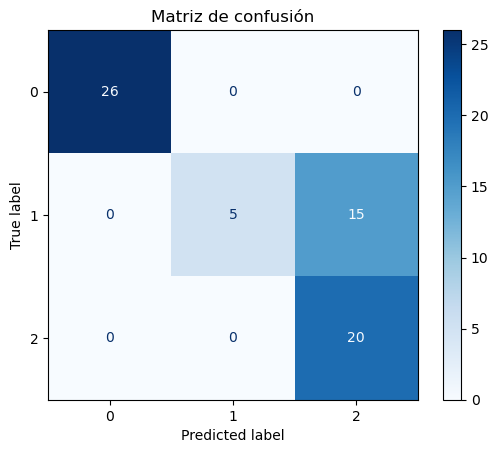

In [6]:
test_model(test_loader, name_model='ModelA_raw.pth')

### Bilateral

C:\Users\richa\AppData\Local\Temp\ipykernel_9480\2231469803.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50.load_state_dict(torch.load(name_model))


Accuracy: 0.9394
Precision: 0.9368
Recall: 0.9333
F1: 0.9347


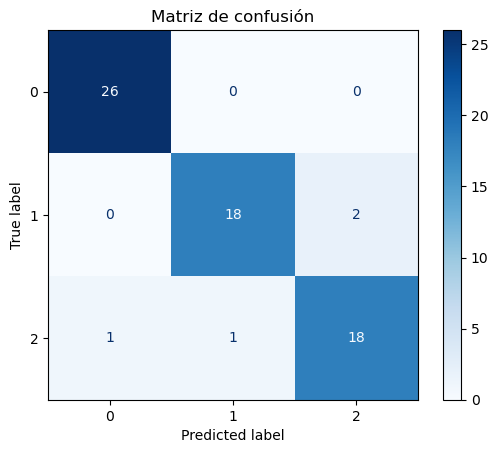

In [12]:
test_model(test_loader_bilateral, name_model='ModelA_bilateral.pth')

### Canny

C:\Users\richa\AppData\Local\Temp\ipykernel_9480\2231469803.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50.load_state_dict(torch.load(name_model))


Accuracy: 0.8333
Precision: 0.8817
Recall: 0.8244
F1: 0.8180


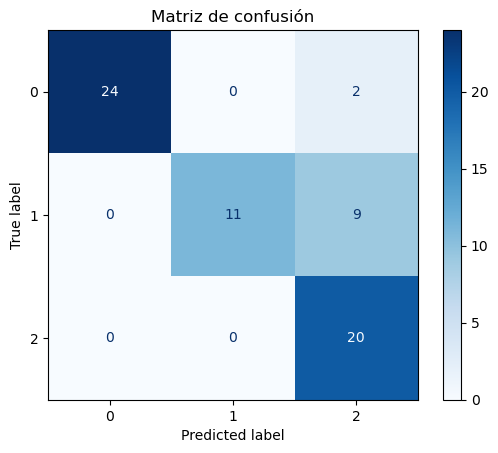

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [13]:
test_model(test_loader_canny, name_model='ModelA_canny.pth')